## Compute and store binned Lagrangian diagnostics : 

Mean velocity fields : 
1) Total velocity : $<u>$, $<v>$, $<\sqrt{u^2+v^2}>$
2) Eulerian interpolated mean velocity : $<\bar u_i>$, $<\bar v_i>$, $<\sqrt{\bar u_i^2+\bar v_i^2}>$
3) Total velocity minus mean velocity : $<(u-\bar u_i)>$, $<(v-\bar v_i)>$, $<\sqrt{(u-\bar u_i)^2+(v-\bar v_i)^2}>$

Mean of squared fields : 
1) Total velocity : $<u^2>$, $<v^2>$, $<u^2+v^2>$
2) Eulerian interpolated mean velocity : $<\bar u_i^2>$, $<\bar v_i^2>$, $<\bar u_i^2+\bar v_i^2>$
3) Total velocity minus men velocity : $<(u-\bar u_i)^2>$, $<(v-\bar v_i)^2>$, $<(u-\bar u_i)^2+(v-\bar v_i)^2>$



In [1]:
import numpy as np

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

import mitequinox.utils as ut
import mitequinox.plot as pl
import mitequinox.parcels as pa
from xmitgcm import llcreader

from fsspec.implementations.local import LocalFileSystem

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5042143.datarmor0/parcels-502090/libparcels_random_4ff01c7a-f9fc-4be6-84f4-a6d5a6682067.so


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=10
                 )
#
client = Client(cluster)


In [3]:
client

Client Scheduler: tcp://10.148.0.134:41334 Dashboard: http://10.148.0.134:8787/status,Cluster Workers: 70 Cores: 70 Memory: 1.09 TiB


### Load dataframe

In [4]:
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time_mean'])
df = p.df['time_mean']

df = pa.degs2ms(df) #Convert in m/s 

#df = df.persist()

In [5]:
#Subdataframe : we keep only velocity field
df_uv = df.drop(columns = ['sea_level','temperature','salinity','SST_interp','SSS_interp','Eta_interp']) #drop unused variables

df_uv = df_uv.rename(columns={'SSU_interp':'mean_zonal_velocity','SSV_interp':'mean_meridional_velocity'})#.persist()

### Binned statistics : 

In [6]:
# geographical bins
dl = 1.
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-90.,90., dl)


In [7]:
import pandas as pd
df_uv['lon'] = (df_uv['lon']+180)%360 - 180
df_uv['lon_cut'] = df_uv['lon'].map_partitions(pd.cut, lon_bins)
df_uv['lat_cut'] = df_uv['lat'].map_partitions(pd.cut, lat_bins)


In [8]:
df_uv = df_uv.persist()

In [9]:
df_uv

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,mean_zonal_velocity,mean_meridional_velocity,lon_cut,lat_cut
npartitions=749,,,,,,,,,,
,int32,float64,float64,float64,float64,float32,float64,float64,category[known],category[known]
,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...


In [10]:
f = lambda x : x.groupby(['lon_cut','lat_cut']).transform('mean')
def my_map(df):
    z = df.map_partitions(f)
    df = df.assign(bmean_zonal_velocity=z['zonal_velocity'])
    df = df.assign(bmean_meridional_velocity=z['meridional_velocity'])
    return df

In [11]:
df_uv = my_map(df_uv)

In [12]:
df_uv = df_uv.persist()

In [15]:
for V in ['zonal_velocity','meridional_velocity']:
    df_uv[V+'_bprime'] = (df_uv[V]-df_uv['bmean_'+V])
df_uv = df_uv.persist()

In [16]:
df_uv['velocity_amplitude_bprime'] = np.sqrt(df_uv['zonal_velocity_bprime']**2+df_uv['meridional_velocity_bprime']**2)

In [17]:
columns = ['zonal_velocity','meridional_velocity']
group = ['lon_cut','lat_cut']
for V in columns:
    df_uv[V+'_iprime'] = df_uv[V].sub(df_uv['mean_'+V])
df_uv = df_uv.persist()

In [18]:
df_uv['velocity_amplitude'] = np.sqrt(df_uv['zonal_velocity']**2+df_uv['meridional_velocity']**2)
df_uv['mean_velocity_amplitude'] = np.sqrt(df_uv['mean_zonal_velocity']**2+df_uv['mean_meridional_velocity']**2)
df_uv['velocity_amplitude_iprime'] = np.sqrt(df_uv['zonal_velocity_iprime']**2+df_uv['meridional_velocity_iprime']**2)
df_uv['bmean_velocity_amplitude'] = np.sqrt(df_uv['bmean_zonal_velocity']**2+df_uv['bmean_meridional_velocity']**2)

In [19]:
df_uv = df_uv.persist()
df_uv

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,mean_zonal_velocity,mean_meridional_velocity,lon_cut,lat_cut,bmean_zonal_velocity,bmean_meridional_velocity,zonal_velocity_bprime,meridional_velocity_bprime,velocity_amplitude_bprime,zonal_velocity_iprime,meridional_velocity_iprime,velocity_amplitude,mean_velocity_amplitude,velocity_amplitude_iprime,bmean_velocity_amplitude
npartitions=749,,,,,,,,,,,,,,,,,,,,,
,int32,float64,float64,float64,float64,float32,float64,float64,category[known],category[known],float64,float32,float64,float32,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [23]:
#Square
for V in df_uv.drop(columns=['lat','lon','trajectory','z','lon_cut','lat_cut']).columns:#df_uv.columns[4:8]:
    df_uv[V+'_sq'] = df_uv[V]*df_uv[V]

In [24]:
df_uv = df_uv.persist()

In [31]:
df_uv = df_uv.drop(columns=['mean_zonal_velocity','mean_meridional_velocity','mean_velocity_amplitude',
                            'mean_zonal_velocity_sq','mean_meridional_velocity_sq','mean_velocity_amplitude_sq'])

In [18]:
df_uv

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,mean_zonal_velocity,mean_meridional_velocity,zonal_velocity_iprime,meridional_velocity_iprime,velocity_amplitude,mean_velocity_amplitude,velocity_amplitude_iprime,zonal_velocity_sq,meridional_velocity_sq,mean_zonal_velocity_sq,mean_meridional_velocity_sq,zonal_velocity_iprime_sq,meridional_velocity_iprime_sq,velocity_amplitude_sq,mean_velocity_amplitude_sq,velocity_amplitude_iprime_sq
npartitions=749,,,,,,,,,,,,,,,,,,,,,,
,int32,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


### Compute mean : 

In [25]:
df_mean = df_uv.groupby([df_uv.lon_cut, df_uv.lat_cut]).mean().compute()

df_mean = pa.add_geodata(df_mean)
#count['density'] = count['count']/count['area']

df_mean = (df_mean
      .drop(columns=['Coordinates'])
      .set_index(['lon', 'lat'])
     .to_xarray()
    )

### Store diagnostics

In [26]:
# Drop useless columns
df_mean = df_mean.drop(['z','trajectory'])

In [27]:
df_mean.attrs.update(**{'run_name': run_name,'dl': dl})

In [28]:
df_mean

<xarray.Dataset>
Dimensions:                         (lat: 179, lon: 359)
Coordinates:
  * lon                             (lon) float64 -179.5 -178.5 ... 177.5 178.5
  * lat                             (lat) float64 -89.5 -88.5 ... 87.5 88.5
Data variables: (12/35)
    zonal_velocity                  (lon, lat) float64 nan nan nan ... nan nan
    meridional_velocity             (lon, lat) float64 nan nan nan ... nan nan
    mean_zonal_velocity             (lon, lat) float64 nan nan nan ... nan nan
    mean_meridional_velocity        (lon, lat) float64 nan nan nan ... nan nan
    bmean_zonal_velocity            (lon, lat) float64 nan nan nan ... nan nan
    bmean_meridional_velocity       (lon, lat) float64 nan nan nan ... nan nan
    ...                              ...
    bmean_velocity_amplitude_sq     (lon, lat) float64 nan nan nan ... nan nan
    zonal_velocity_sq_sq            (lon, lat) float64 nan nan nan ... nan nan
    meridional_velocity_sq_sq       (lon, lat) float64 nan nan nan ... nan nan
    mean_zonal_velocity_sq_sq       (lon, lat) float64 nan nan nan ... nan nan
    mean_meridional_velocity_sq_sq  (lon, lat) float64 nan nan nan ... nan nan
    area                            (lon, lat) float64 nan 49.22 ... 28.8 49.22
Attributes:
    run_name:  global_extra_T365j_dt1j_dij50
    dl:        1.0

In [29]:
#store dataset in diagnostics directory
p.store_diagnostic("L_dl"+str(dl)+"_stats", df_mean,overwrite=True)

L_dl1.0_stats diagnostics stored in /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/diagnostics/L_dl1.0_stats.zarr


### Load diagnostics

In [30]:
df_mean = p.load_diagnostic('L_dl1.0_stats.zarr')

In [31]:
df_mean.load()

<xarray.Dataset>
Dimensions:                         (lat: 179, lon: 359)
Coordinates:
  * lat                             (lat) float64 -89.5 -88.5 ... 87.5 88.5
  * lon                             (lon) float64 -179.5 -178.5 ... 177.5 178.5
Data variables: (12/35)
    area                            (lon, lat) float64 nan 49.22 ... 28.8 49.22
    bmean_meridional_velocity       (lon, lat) float64 nan nan nan ... nan nan
    bmean_meridional_velocity_sq    (lon, lat) float64 nan nan nan ... nan nan
    bmean_velocity_amplitude        (lon, lat) float64 nan nan nan ... nan nan
    bmean_velocity_amplitude_sq     (lon, lat) float64 nan nan nan ... nan nan
    bmean_zonal_velocity            (lon, lat) float64 nan nan nan ... nan nan
    ...                              ...
    zonal_velocity_bprime           (lon, lat) float64 nan nan nan ... nan nan
    zonal_velocity_bprime_sq        (lon, lat) float64 nan nan nan ... nan nan
    zonal_velocity_iprime           (lon, lat) float64 nan nan nan ... nan nan
    zonal_velocity_iprime_sq        (lon, lat) float64 nan nan nan ... nan nan
    zonal_velocity_sq               (lon, lat) float64 nan nan nan ... nan nan
    zonal_velocity_sq_sq            (lon, lat) float64 nan nan nan ... nan nan
Attributes:
    dl:        1.0
    run_name:  global_extra_T365j_dt1j_dij50

### Visualization : 

#### Mean flow : Lagrangian raw velocity, $<u>$

$<.>$ : average over bin and time


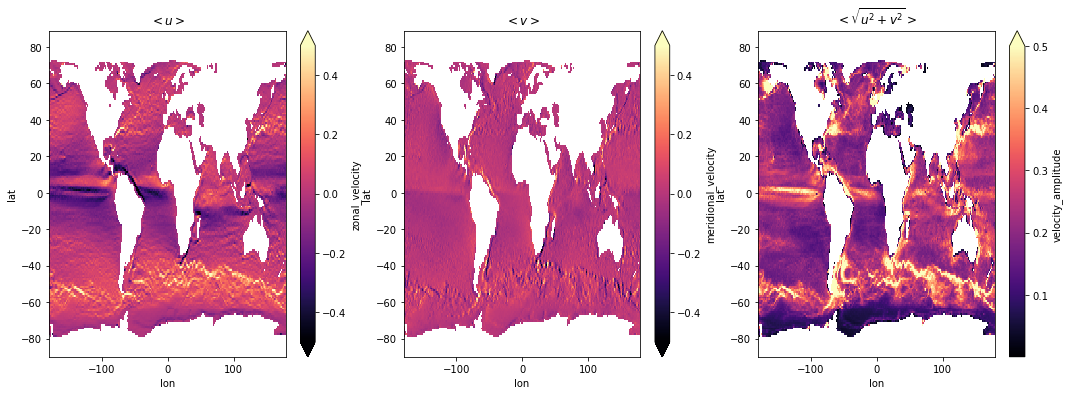

In [42]:
columns = ['zonal_velocity','meridional_velocity','velocity_amplitude']
figsize=(6*len(columns),6)
fig,axs = plt.subplots(1,len(columns),figsize=figsize)#,subplot_kw=dict(projection=projection))
for V, ax,title in zip(columns,axs,[r'$<u>$',r'$<v>$',r'$<\sqrt{u^2+v^2}>$']):    
    df_mean[V].plot(ax=ax,x='lon',vmax=0.5,cmap='magma')
    ax.set_title(title)

#### Mean flow : Total velocity minus interpolated Eulerian mean, $<u_i'>=<u-\bar u_i>$
$<.>$ : average over bin and time

$\bar .$ : temporal average

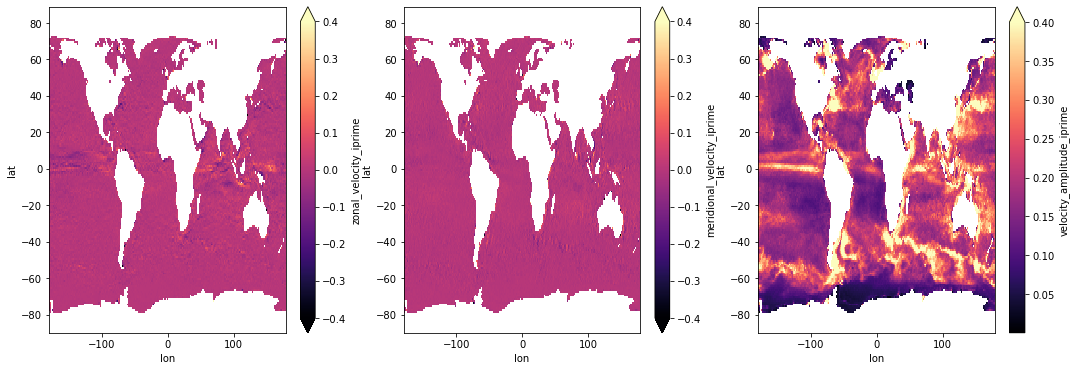

In [32]:
columns = ['zonal_velocity_iprime','meridional_velocity_iprime','velocity_amplitude_iprime']
figsize=(6*len(columns),6)
fig,axs = plt.subplots(1,len(columns),figsize=figsize)#,subplot_kw=dict(projection=projection))
for V, ax,title in zip(columns,axs,[r'$<u-\bar u_i>$',r'$<v-\bar v_i>$',r'$<\sqrt{(u-\bar u_i)^2+(v-\bar v_i)^2}>$']):

    df_mean[V].plot(ax=ax,x='lon',vmax=0.4,cmap='magma')
    ax.set_title(title)

#### Mean flow : Total velocity minus binned mean, $<u_b'>=<u-\bar u_b>$
$<.>$ : average over bin and time

$\bar .$ : temporal and binend average

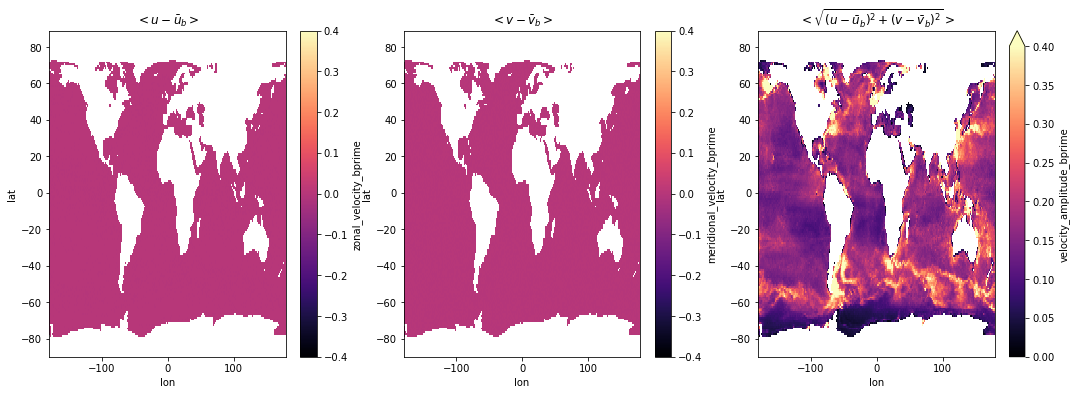

In [40]:
columns = ['zonal_velocity_bprime','meridional_velocity_bprime','velocity_amplitude_bprime']
figsize=(6*len(columns),6)
fig,axs = plt.subplots(1,len(columns),figsize=figsize)#,subplot_kw=dict(projection=projection))
for V, ax,title in zip(columns,axs,[r'$<u-\bar u_b>$',r'$<v-\bar v_b>$',r'$<\sqrt{(u-\bar u_b)^2+(v-\bar v_b)^2}>$']):

    df_mean[V].plot(ax=ax,x='lon',vmax=0.4,cmap='magma')
    ax.set_title(title)

#### Variance : $<u^2>$
$<.>$ : average over bin and time

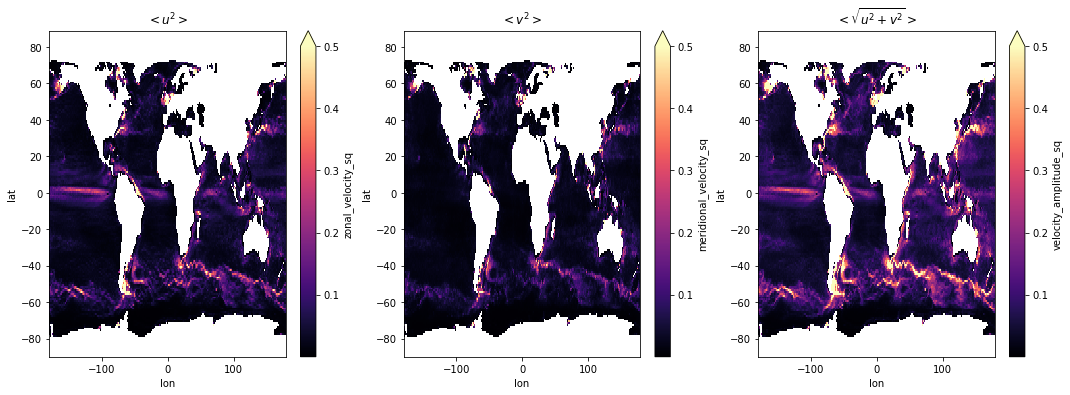

In [38]:
columns = ['zonal_velocity','meridional_velocity','velocity_amplitude']
figsize=(6*len(columns),6)
fig,axs = plt.subplots(1,len(columns),figsize=figsize)#,subplot_kw=dict(projection=projection))
for V, ax,title in zip(columns,axs,[r'$<u^2>$',r'$<v^2>$',r'$<\sqrt{u^2+v^2}>$']):

    df_mean[V+'_sq'].plot(ax=ax,x='lon',vmax=0.5,cmap='magma')
    ax.set_title(title)

#### EKE : interpolated mean, $<u_i'^2>=<(u-\bar u_i)^2>$
$<.>$ : average over bin and time

$\bar .$ : temporal average

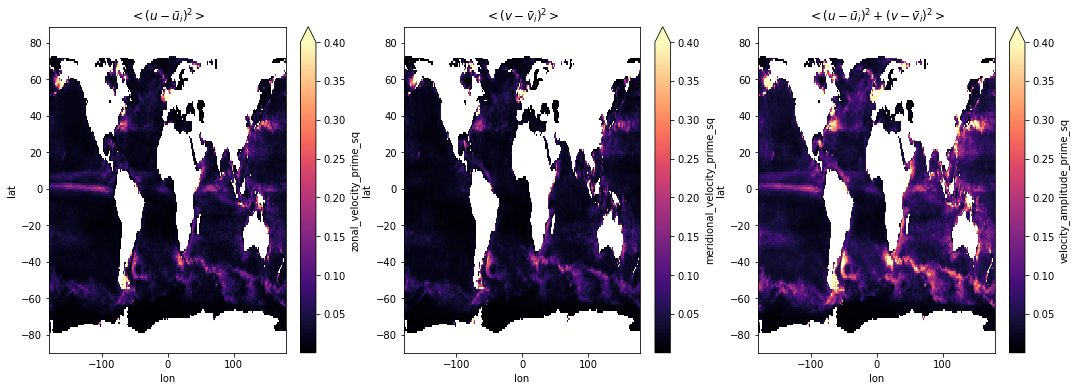

In [10]:
columns = ['zonal_velocity_iprime','meridional_velocity_iprime','velocity_amplitude_iprime']
figsize=(6*len(columns),6)
fig,axs = plt.subplots(1,len(columns),figsize=figsize)#,subplot_kw=dict(projection=projection))
for V, ax,title in zip(columns,axs,[r'$<(u-\bar u_i)^2>$',r'$<(v-\bar v_i)^2>$',r'$<(u-\bar u_i)^2+(v-\bar v_i)^2>$']):
    df_mean[V+'_sq'].plot(ax=ax,x='lon',vmax=0.4,cmap='magma')
    ax.set_title(title)

#### EKE : binned mean, $<u_b'^2>=<(u-\bar u_b)^2>$
$<.>$ : average over bin and time

$\bar .$ : temporal and binned average

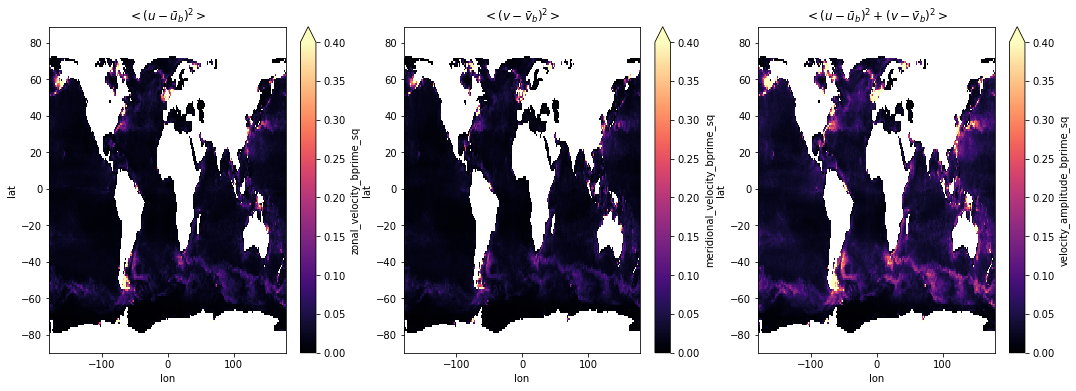

In [36]:
columns = ['zonal_velocity_bprime','meridional_velocity_bprime','velocity_amplitude_bprime']
figsize=(6*len(columns),6)
fig,axs = plt.subplots(1,len(columns),figsize=figsize)#,subplot_kw=dict(projection=projection))
for V, ax,title in zip(columns,axs,[r'$<(u-\bar u_b)^2>$',r'$<(v-\bar v_b)^2>$',r'$<(u-\bar u_b)^2+(v-\bar v_b)^2>$']):
    df_mean[V+'_sq'].plot(ax=ax,x='lon',vmax=0.4,cmap='magma')
    ax.set_title(title)

#### rms : interpolated mean, $\sqrt{<u_i'^2>}=\sqrt{<(u-\bar u_i)^2>}$
$<.>$ : average over bin and time

$\bar .$ : temporal average

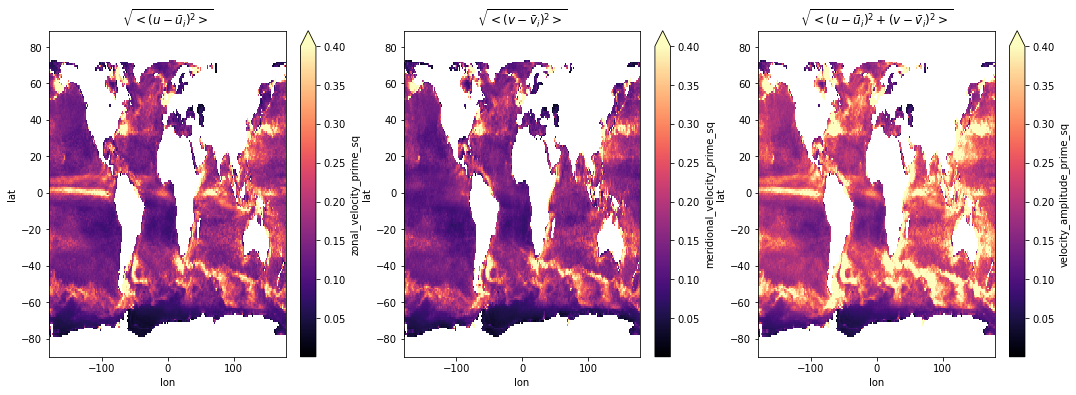

In [11]:
columns = ['zonal_velocity_iprime','meridional_velocity_iprime','velocity_amplitude_iprime']
figsize=(6*len(columns),6)
fig,axs = plt.subplots(1,len(columns),figsize=figsize)#,subplot_kw=dict(projection=projection))
for V, ax, title in zip(columns,axs,[r'$\sqrt{<(u-\bar u_i)^2>}$',r'$\sqrt{<(v-\bar v_i)^2>}$',r'$\sqrt{<(u-\bar u_i)^2+(v-\bar v_i)^2>}$']):
    np.sqrt(df_mean[V+'_sq']).plot(ax=ax,x='lon',vmax=0.4,cmap='magma')
    ax.set_title(title)

#### rms : binned mean, $\sqrt{<u_b'^2>}=\sqrt{<(u-\bar u_b)^2>}$
$<.>$ : average over bin and time

$\bar .$ : temporal and binned average

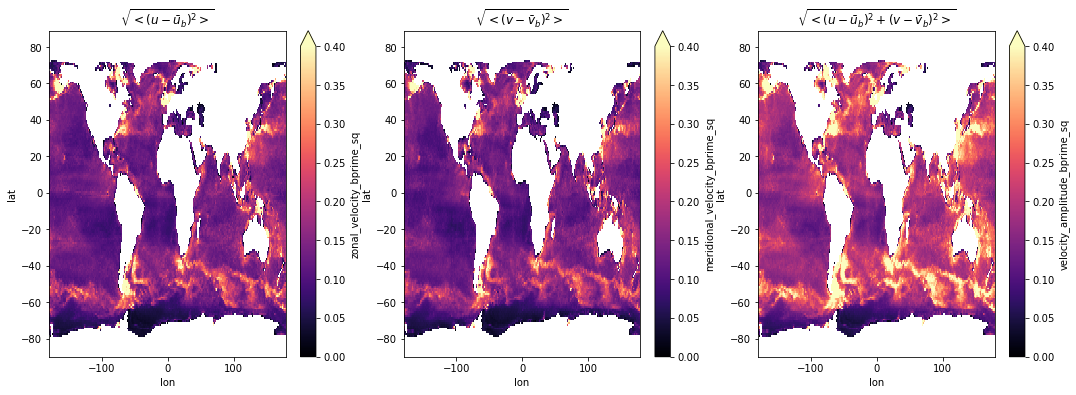

In [37]:
columns = ['zonal_velocity_bprime','meridional_velocity_bprime','velocity_amplitude_bprime']
figsize=(6*len(columns),6)
fig,axs = plt.subplots(1,len(columns),figsize=figsize)#,subplot_kw=dict(projection=projection))
for V, ax, title in zip(columns,axs,[r'$\sqrt{<(u-\bar u_b)^2>}$',r'$\sqrt{<(v-\bar v_b)^2>}$',r'$\sqrt{<(u-\bar u_b)^2+(v-\bar v_b)^2>}$']):
    np.sqrt(df_mean[V+'_sq']).plot(ax=ax,x='lon',vmax=0.4,cmap='magma')
    ax.set_title(title)

In [43]:
cluster.close()